# 使用 Apriori 算法进行关联分析

## 关联分析
关联分析是一种在大规模数据集中寻找有趣关系的任务。 这些关系可以有两种形式:
-   频繁项集（frequent item sets）: 经常出现在一块的物品的集合。
-   关联规则（associational rules）: 暗示两种物品之间可能存在很强的关系。

### 一个例子
-   数据集：一个超市的购物记录。
-   每条记录表示一位顾客的购物篮，例如：
  ```text
  [牛奶, 面包, 黄油]
  [面包, 黄油, 鸡蛋]
  [牛奶, 面包, 鸡蛋]
  [牛奶, 黄油, 鸡蛋]
  [牛奶, 面包, 黄油, 鸡蛋]
  ```

**频繁项集**
-    支持度阈值设为 3（至少在 3 条记录中出现）。
-   找到的频繁项集：
  - {牛奶, 面包}: 出现 3 次
  - {面包, 黄油}: 出现 3 次
  - {牛奶, 面包, 鸡蛋}: 出现 3 次

**关联规则**
关联规则表示两组物品之间的可能关系，通常以形式 A → B 表示，意为“购买了 A 的顾客倾向于购买 B”。
- 频繁项集 {牛奶, 面包} 中包含两个商品，可能的关联规则为：
  - 牛奶 → 面包：购买牛奶的顾客也倾向于购买面包。
  - 面包 → 牛奶：购买面包的顾客也倾向于购买牛奶。

### 量化关联规则
**支持度**
- 表示规则涉及的所有商品一起出现的频率。
- 公式：Support(A → B) = P(A ∩ B)
- 例如：Support(牛奶 → 面包) = 3/5 = 0.6

**置信度**
- 表示在包含 A 的交易中，同时包含 B 的概率。
- 公式：Confidence(A → B) = P(B | A) = P(A ∩ B) / P(A)
- 例如：Confidence(牛奶 → 面包) = 3/4 = 0.75

## Apriori 原理
Apriori原理是关联规则挖掘中一个重要的理论基础，主要用于高效发现频繁项集。它基于以下关键思想：
- 如果一个项集是频繁的，那么它的所有子集也一定是频繁的；
- 反过来说，如果一个项集不是频繁的，那么它的超集也一定不是频繁的。

Apriori 原理用于剪枝：通过剔除不可能成为频繁项集的候选项集，减少搜索空间，从而提高算法效率。

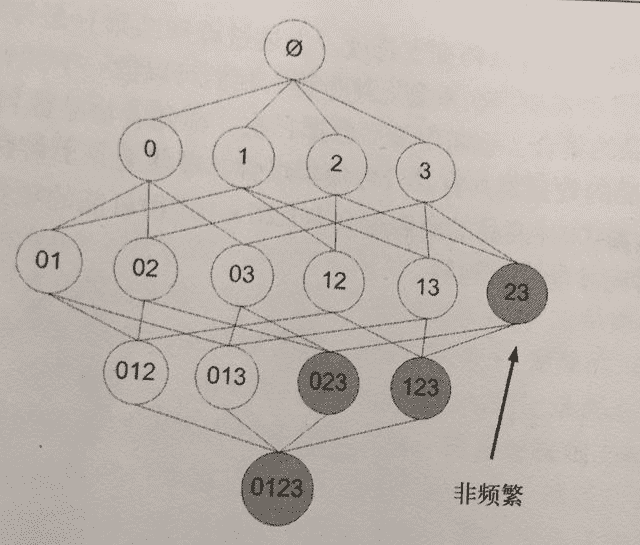
- 在如图的的示例中，因为23是不频繁的，所以其子集也都是不频繁的，并依次传递下去

## 算法流程

### **1. 输入**
- **事务数据库**：包含多个交易记录，每条记录是一组商品（项集）。
- **支持度阈值（min\_support）**：项集被认为是频繁的最低支持度。

### **2. 输出**
- 所有满足支持度阈值的**频繁项集**。

---

## 步骤描述

以下是 Apriori 算法的具体步骤：

### **步骤 1：扫描数据，生成候选项集 $C_1$**
- 从事务数据库中找出所有的单个项（商品）。
- 将每个单个商品作为一个候选项集，并计算其**支持度**。

### **步骤 2：筛选频繁项集 $L_1$**
- 对 $C_1$ 中的每个候选项集，筛选出支持度大于等于 `min\_support` 的项集，形成频繁 1 项集 $L_1$。

### **步骤 3：生成 $k$-候选项集 $C_k$**
- 利用 $L_{k-1}$ 的频繁项集，连接生成 $k$-项候选项集 $C_k$：
  $$
  C_k = \{ A \cup B \mid A, B \in L_{k-1}, |A \cap B| = k-2 \}
  $$
  - 即寻找交集为 k-2 个元素的集合，然后各自加上自己独有的1个元素，最后得到 k 个元素的新的集合
- 利用 **Apriori 原理** 剪枝：
  - 如果 $k$-候选项集中的任意 $k-1$ 子集不是频繁项集，则剔除该项集。

### **步骤 4：扫描数据库，计算 $C_k$ 的支持度**
- 对 $C_k$ 中的每个候选项集，扫描事务数据库，统计其出现的频率，计算支持度。

### **步骤 5：生成 $k$-频繁项集 $L_k$**
- 筛选 $C_k$ 中支持度大于等于 `min\_support` 的项集，形成 $k$-频繁项集 $L_k$。

### **步骤 6：重复步骤 3~5**
- 不断生成更大的候选项集，并筛选出频繁项集，直到不能生成新的候选项集（即 $L_k$ 为空）。

### **步骤 7：输出所有频繁项集**
- 将所有频繁项集 $L_1, L_2, \dots, L_k$ 作为最终输出。


In [ ]:
import pandas as pd
import numpy as np
from itertools import combinations

# 创建初始候选集 C1
def create_candidate_set(dataFrame):
    """
    创建初始候选项集 C1。
    
    Args:
        dataFrame: Pandas DataFrame，每列表示一个商品，每行表示一次交易，值为 0 或 1
    Returns:
        C1: 候选项集。
    """
    items = dataFrame.columns
    return [{item} for item in items]


# 扫描数据集，筛选频繁项集
def scan_dataset(dataFrame, candidateSet, minSupport):
    """
    计算候选项集的支持度，并返回满足最小支持度的频繁项集。
    
    Args:
        dataFrame: Pandas DataFrame，交易数据。
        candidateSet: 候选项集。
        minSupport: 最小支持度阈值。
    Returns:
        frequentSet: 满足支持度的频繁项集。
        supportData: 候选项集及其对应的支持度字典。
    """